# SK Part 2: Feature Selection and Ranking
***

The topics of this tutorial are feature selection and feature ranking (such as "what are the most important 5 features?"). Feature selection is usually an overlooked issue in machine learning. In many cases, using all the descriptive features that are available can lead to excessive computational times, overfitting, and poor performance in general. It's always a good idea to check to see if we can achieve better performance by employing some sort of feature selection before fitting a model. Feature selection can also be performed in conjunction with the modeling process (as part of a machine learning pipeline), which is discussed in **SK Part 5**.

## Learning Objectives
* Perform feature selection and ranking using the following methods:
  - F-score (a statistical filter method)
  - Mutual information (an entropy-based filter method)
  - Random forest importance (an ensemble-based filter method)
  - SPSA (a new wrapper method developed by [V. Aksakalli et al.](https://arxiv.org/abs/1804.05589))
* Compare performance of feature selection methods using paired t-tests. 

First, let's discuss some terminology.

The classifier used to assess performance of the feature selection methods is called the "wrapper". Here, we use the 1-nearest neighbor as the wrapper. As for the sample data, we use the breast cancer Wisconsin dataset.

The first three methods are "filter methods": they examine the relationship between the descriptive features and the target feature and they select features only once regardless of which classifier shall be used subsequently.

The last method is a "wrapper method": it selects a different set of features for each wrapper. Wrapper feature selection methods are relatively slow and they need to be executed again when a different wrapper is used. For instance, the best 5 features selected by a wrapper method for 1-nearest neighbor will probably be different than the best 5 features for decision trees. However, wrapper methods attempt to solve the "real problem": "what the best subset of features when, say, the 1-nearest neighbor classifier is used?". They tend to perform somewhat better than the filter methods at the cost of more computational resources and a different set of features for each classifier.

## Table of Contents
  * [Data Preparation](#Data-Preparation)
  * [Performance with Full Set of Features](#Performance-with-Full-Set-of-Features)
  * [Feature Selection Using F-Score](#Feature-Selection-Using-F-Score)
  * [Feature Selection Using Mutual Information](#Feature-Selection-Using-Mutual-Information)
  * [Feature Selection Using Random Forest Importance](#Feature-Selection-Using-Random-Forest-Importance)
  * [Feature Selection Using SPSA](#Feature-Selection-Using-SPSA)
  * [Performance Comparison Using Paired T-Tests](#Performance-Comparison-Using-Paired-T-Tests)

## Data Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.neighbors import KNeighborsClassifier

Let's load the dataset from the Cloud.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

# for Mac OS users only!
# if you run into any SSL certification issues, 
# you may need to run the following command for a Mac OS installation.
# $/Applications/Python 3.x/Install Certificates.command
# if this does not fix the issue, please run the code chunk below
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

cancer_url = 'https://raw.githubusercontent.com/vaksakalli/datasets/master/breast_cancer_wisconsin.csv'
url_content = requests.get(cancer_url).content
cancer_df = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

cancer_df.shape

(569, 31)

Let's have a look at the first 5 rows to see what the dataset looks like. Here, the last column "diagnosis" is the target variable.

In [3]:
cancer_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


Let's do some pre-processing:
- Split the dataset columns into `Data` and `target`.
- Make target numeric by label-encoding.
- Normalize each descriptive feature in `Data` to be between 0 and 1.

In [4]:
Data = cancer_df.drop(columns = 'diagnosis').values
target = cancer_df['diagnosis']
Data = preprocessing.MinMaxScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)

## Performance with Full Set of Features

As wrapper, we use the 1-nearest neighbor classifier.

In [5]:
clf = KNeighborsClassifier(n_neighbors=1)

First, we would like to assess performance using all the features in the dataset. For assessment, we shall use stratified 5-fold cross-validation with 3 repetitions. We set the random state to 999 so that our results can be replicated and verified later on exactly as they are.

In [6]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                     random_state=999)

For scoring, we use the accuracy score.

In [7]:
scoring_metric = 'accuracy'

Let's perform the cross-validation using the `cross_val_score` function.

In [8]:
cv_results_full = cross_val_score(estimator=clf,
                             X=Data,
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)

The array `cv_results_full` contains 15 values corresponding to each one of the 3-repetition/ 5-fold combinations.

In [9]:
cv_results_full

array([0.95652174, 0.93043478, 0.95575221, 0.97345133, 0.9380531 ,
       0.93043478, 0.96521739, 0.94690265, 0.96460177, 0.96460177,
       0.95652174, 0.96521739, 0.96460177, 0.9380531 , 0.96460177])

We compute the average cross-validation performance as the mean of the `cv_results_full` array.

In [10]:
cv_results_full.mean().round(3)

0.954

So, with the full set of features and with the 1-nearest neighbor classifier as our wrapper, we achieve an average accuracy of 95.4%.

Let's now select the best 5 features in the dataset using different methods.

In [11]:
num_features = 5

## Feature Selection Using F-Score

The F-score method is a filter feature selection method that looks at the relationship between each descriptive feature and the target feature using the F-distribution. 

The code below returns the indices of the 5 features that have the highest f-score value sorted from the highest to the lowest. Pay attention that the wrapper is not used in any way when selecting features using the F-score method.

In [12]:
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:num_features]
fs_indices_fscore

array([27, 22,  7, 20,  2])

Let's see what these 5 best features are.

In [13]:
best_features_fscore = cancer_df.columns[fs_indices_fscore].values
best_features_fscore

array(['worst_concave_points', 'worst_perimeter', 'mean_concave_points',
       'worst_radius', 'mean_perimeter'], dtype=object)

Based on the F-scores, we observe that, out of the top 5 features, the most important feature is "worst_concave_points" and the least important feature is "mean_perimeter".

The F-score importances of these features are given below.

In [14]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([964.38539345, 897.94421886, 861.67602001, 860.78170699,
       697.23527248])

We define a function for plotting so that we can plot other importance types as well corresponding to different feature selection methods.

In [15]:
import altair as alt

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.75, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

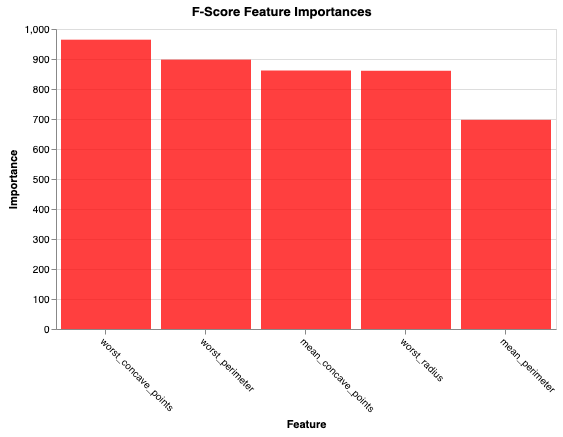

In [16]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score', 'red')

We can select those features from the set of descriptive features `Data` using slicing as shown below.

In [17]:
Data[:, fs_indices_fscore].shape

(569, 5)

Let's now assess performance of this feature selection method using cross validation with the 1-nearest neighbor classifier.

In [18]:
cv_results_fscore = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_fscore],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_fscore.mean().round(3)

0.928

## Feature Selection Using Mutual Information

The mutual information method is a filter feature selection method that looks at the relationship between each descriptive feature and the target feature using the concept of entropy.

The code below returns the indices of the 5 features that have the highest mutual information value. As in the F-score method, the wrapper is not used in any way when selecting features using the mutual information method.

In [19]:
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=num_features)
fs_fit_mutual_info.fit_transform(Data, target)
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = cancer_df.columns[fs_indices_mutual_info].values
best_features_mutual_info

array(['worst_perimeter', 'worst_area', 'worst_radius',
       'mean_concave_points', 'worst_concave_points'], dtype=object)

In [20]:
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
feature_importances_mutual_info

array([0.47525803, 0.4653155 , 0.45064777, 0.44027448, 0.43495608])

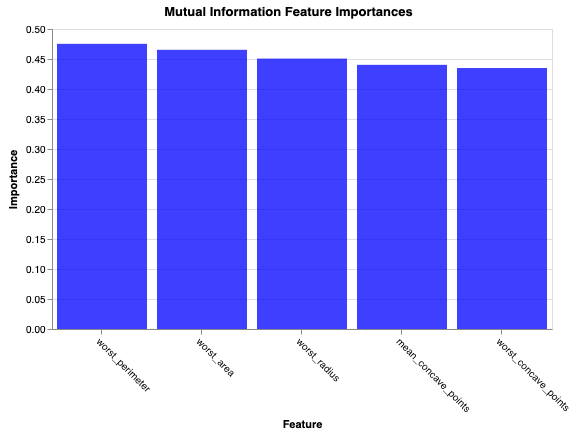

In [21]:
plot_imp(best_features_mutual_info, feature_importances_mutual_info, 'Mutual Information', 'blue')

Now let's evaluate the performance of these features.

In [22]:
cv_results_mutual_info = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_mutual_info],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_mutual_info.mean().round(3)

0.92

## Feature Selection Using Random Forest Importance

The random forest importance (RFI) method is a filter feature selection method that uses the total decrease in node impurities from splitting on a particular feature as averaged over all decision trees in the ensemble. For classification, the node impurity is measured by the Gini index and for regression, it is measured by residual sum of squares.

Let's perform RFI feature selection using 100 trees.

In [23]:
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

Here are the best features selected by RFI.

In [24]:
best_features_rfi = cancer_df.columns[fs_indices_rfi].values
best_features_rfi

array(['worst_area', 'worst_perimeter', 'worst_radius',
       'worst_concave_points', 'mean_concave_points'], dtype=object)

In [25]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.15867628, 0.12152954, 0.11511165, 0.1096993 , 0.09649208])

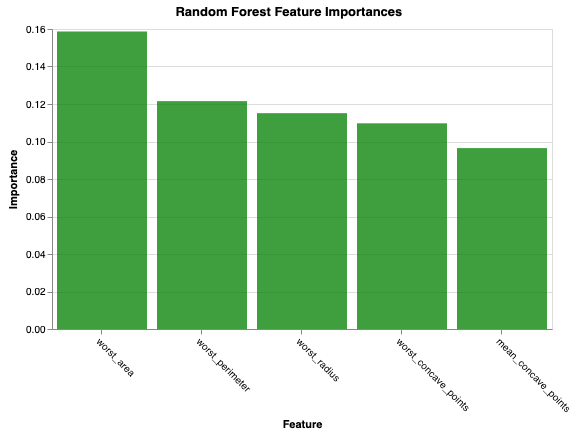

In [26]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'green')

Now let's evaluate the performance of these features.

In [27]:
cv_results_rfi = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_rfi],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_rfi.mean().round(3)

0.92

## Feature Selection Using SPSA

SPSA is a new wrapper-based feature selection method that uses binary stochastic approximation. An R implementation is available within the `spFSR` package and a Python implementation can be found on [github](https://github.com/vaksakalli/spsaml_py). Please refer to this [arxiv](https://arxiv.org/abs/1804.05589) paper for more information on this method.

In order for this example to work, you need to make sure that you download and copy the Python file `SpFtSel.py` under the same directory as your Jupyter notebook so that the import works correctly.

Let's define a SpFtSel object with our feature selection problem with 'accuracy' as our performance metric.

In [28]:
from SpFtSel import SpFtSel

sp_engine = SpFtSel(Data, target, clf, 'accuracy')

Let's now run the SPSA method and the indices of the best features.

In [29]:
np.random.seed(999)
sp_output = sp_engine.run(num_features).results

spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
spFtSel-INFO: Scoring metric: accuracy
spFtSel-INFO: Number of features: 30
spFtSel-INFO: Number of observations: 569
spFtSel-INFO: iter: 0, value: 0.849, std: 0.031, num. features: 5, best value: 0.849
spFtSel-INFO: iter: 5, value: 0.923, std: 0.025, num. features: 5, best value: 0.935
spFtSel-INFO: iter: 10, value: 0.96, std: 0.018, num. features: 5, best value: 0.96
spFtSel-INFO: iter: 15, value: 0.956, std: 0.015, num. features: 5, best value: 0.96
spFtSel-INFO: iter: 20, value: 0.963, std: 0.012, num. features: 5, best value: 0.963
spFtSel-INFO: iter: 25, value: 0.953, std: 0.017, num. features: 5, best value: 0.963
spFtSel-INFO: iter: 30, value: 0.966, std: 0.014, num. features: 5, best value: 0.966
spFtSel-INFO: iter: 35, value: 0.

Let's get the indices of the best features.

In [30]:
fs_indices_spsa = sp_output.get('features')
fs_indices_spsa

array([27, 20, 21, 29, 10])

Let's have a look at the top 5 features selected by SPSA.

In [31]:
best_features_spsa = cancer_df.columns[fs_indices_spsa].values
best_features_spsa

array(['worst_concave_points', 'worst_radius', 'worst_texture',
       'worst_fractal_dimension', 'radius_error'], dtype=object)

In [32]:
feature_importances_spsa = sp_output.get('importance')
feature_importances_spsa

array([1.        , 1.        , 0.93958984, 0.87910849, 0.85585522])

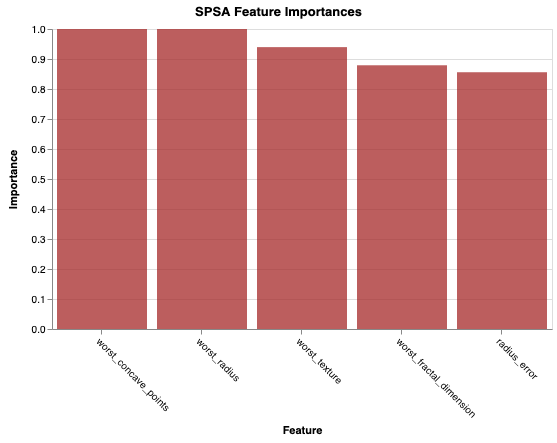

In [33]:
plot_imp(best_features_spsa, feature_importances_spsa, 'SPSA', 'brown')

Finally, let's evaluate the performance of the SPSA feature selection method.

In [34]:
cv_results_spsa = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_spsa],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_spsa.mean().round(3)

0.964

We observe that we get a cross-validation accuracy of 96.4% with SPSA with just 5 features. Recall that the cross-validation accuracy with the full set of features is 95.4%. So, in this particular case, it is remarkable that we can achieve even slightly better results with 5 features selected by SPSA as opposed to using all the 30 features. However, we will need to conduct a t-test to determine if this difference is statistically significant or not.

## Performance Comparison Using Paired T-Tests

For performance assessment, we used repeated cross-validation. However, cross-validation is a random process and we need statistical tests in order to determine if any difference between the performance of any two feature selection methods is statistically significant; or if it is within the sample variation and the difference is statistically insignificant.

Since we fixed the random state to be same for all cross-validation procedures, all feature selection methods were fitted and then tested on exactly the same data partitions. This indicates that our experiments were actually paired. Conducting experiments in a paired fashion reduces the variability significantly compared to conducting experiments in an independent fashion.

Let's now conduct paired t-tests to see which differences between full set of features, filter methods, and SPSA are statistically significant. Let's first remind ourselves the performances.

In [35]:
print('Full Set of Features:', cv_results_full.mean().round(3))
print('F-Score:', cv_results_fscore.mean().round(3))
print('Mutual Information:', cv_results_mutual_info.mean().round(3))
print('RFI:', cv_results_rfi.mean().round(3))
print('SPSA:', cv_results_spsa.mean().round(3)) 

Full Set of Features: 0.954
F-Score: 0.928
Mutual Information: 0.92
RFI: 0.92
SPSA: 0.964


For a paired t-test in Python, we use the `stats.ttest_rel` function inside the `scipy` module and look at the p-values. At a 95% significance level, if the p-value is smaller than 0.05, we  conclude that the difference is statistically significant.

In [36]:
from scipy import stats
print(stats.ttest_rel(cv_results_spsa, cv_results_fscore).pvalue.round(3))
print(stats.ttest_rel(cv_results_spsa, cv_results_mutual_info).pvalue.round(3))
print(stats.ttest_rel(cv_results_spsa, cv_results_rfi).pvalue.round(3))

0.0
0.0
0.0


For SPSA vs. all the other three feature selection methods, we observe a p-value of 0, which indicates SPSA is statically better than F-score, mutual information, and RFI methods.

In [37]:
stats.ttest_rel(cv_results_spsa, cv_results_full).pvalue.round(3)

0.06

For SPSA vs. full set of features, we observe a p-value of 0.06, indicating that the difference is not statically significant. Thus, SPSA with 5 features performs at similar levels as the full set of features, at least for the 1-nearest neighbor classifier.

**Note**: In this notebook, we use all the data to train the feature selection methods and then tested them again on the entire dataset using cross-validation. Despite its simplicity, this approach potentially results in overfitting. In order to mitigate this issue, a more appropriate procedure would be to perform this comparison within a repeated cross-validation scheme: we use two nested for loops (the outer loop for the repetitions and the inner loop for the folds). In the inner loop, we use a particular 80% of the entire data for fitting the feature selection methods and the remaining 20% for evaluation.

***
www.featureranking.com